<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_02_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 11.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity

load nursing notes subject-caregiver-chartdate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


## **Data Preprocessing**

extract nicu notes

In [23]:
def nicu_condition(x):
  words = ['nicu', 'neonatal']
  return any(word in x.lower() for word in words)

# get list of subject in nicu    
nicu_subject_ids = df_notes[df_notes['TEXT'].apply(lambda x: nicu_condition(x))]['SUBJECT_ID'].unique()

# get nicu notes
df_notes_nicu = df_notes[df_notes['SUBJECT_ID'].isin(nicu_subject_ids)]
df_notes_nicu

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
0,2019399,25397,14720,2187-02-16,Social Work:\nHad provider meeting this aftern...
5,1792738,7984,14489,2153-08-30,NICU NURSING FAMILY MEETING AND PARENTING NOTE...
16,2019351,25397,14720,2187-02-08,Social Work:\n\n [**First Name8 (NamePattern2)...
46,2080962,32392,17603,2199-12-05,NPN DAYS\nRECEIVED [**Doctor Last Name **] AT ...
60,1740211,4578,14720,2152-08-09,"Social Work:\nFamily meeting held with mom, Dr..."
...,...,...,...,...,...
531667,1900603,15772,16864,2103-07-04,NPN 7a7p cont\nAgree with the above not writte...
531668,2034585,26106,19530,2191-05-13,Social Work:\nPlease refer to note in baby a's...
531670,1974281,21464,20104,2189-03-18,Procedure Note: UAC removal.\n\nUAC removed in...
531672,1735597,4205,16022,2163-06-11,Addendum\nAgree with above note and assessment...


## Data exploration 

check number of notes per patient/subject

number of notes: min=1, max=67, mean=2.425686113904758,  median=1.0


<Axes: xlabel='TEXT'>

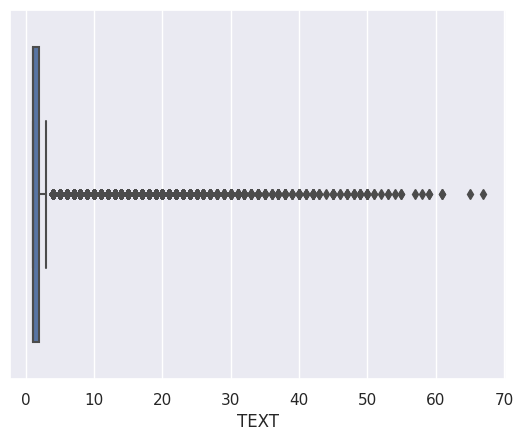

In [24]:
import seaborn as sns
sns.set()


gb_notes = df_notes_nicu.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)

check number of caregiver/subject that have between 4 and 15 notes

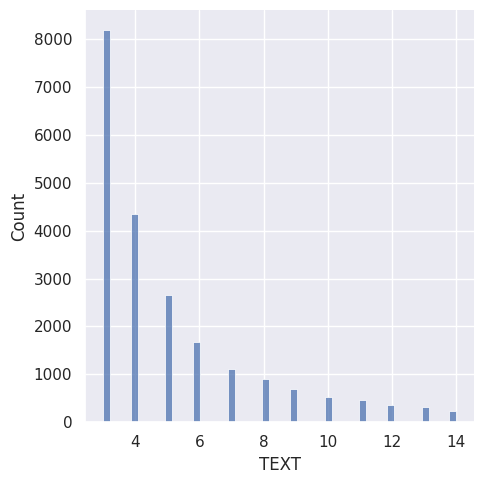

In [48]:
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

## Embedding and Attitude

### Input data

In [ ]:
caregivers_ids = 

In [29]:
ids = num_notes[num_notes==6].index
ids

MultiIndex([(14098,  3027),
            (14098,  4604),
            (14098,  6188),
            (14098,  6380),
            (14098,  6769),
            (14098, 14746),
            (14098, 25625),
            (14151, 26492),
            (14160, 11024),
            (14160, 14287),
            ...
            (20932, 25567),
            (21189, 15232),
            (21334, 12981),
            (21420, 15896),
            (21420, 23378),
            (21528, 14295),
            (21528, 22089),
            (21539, 15310),
            (21570, 16477),
            (21570, 26444)],
           names=['CGID', 'SUBJECT_ID'], length=1673)

In [35]:
# loop through len(ids)
def create_sentences(index=0):
  cgid, subid = ids[index]
  df_notes_nicu_selected = df_notes_nicu[(df_notes_nicu['CGID'] == cgid) & (df_notes_nicu['SUBJECT_ID'] == subid)].sort_values(by=['CHARTDATE'])
  df_notes_nicu_selected
  sentences = df_notes_nicu_selected['TEXT'].tolist()
  return df_notes_nicu_selected, sentences

df_notes_nicu_selected, sentences = create_sentences()

In [37]:
df_notes_nicu_selected

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
197491,1722418,3027,14098,2103-02-16,"1900-0700 NPN\n\n\nRESP: Infant remains in RA,..."
153866,1722421,3027,14098,2103-02-17,"1900-0700 NPN\n\n\nRESP: Infant remains in RA,..."
319382,1722440,3027,14098,2103-02-22,"0700-1900 NPN\n\n\nRESP: Infant remains in RA,..."
255058,1722444,3027,14098,2103-02-23,"0700-1900 NPN\n\n\nRESP: Infant remains in RA,..."
292549,1722463,3027,14098,2103-02-28,"0700-1900 NPN\n\n\nRESP: Infant remains in RA,..."
318809,1722478,3027,14098,2103-03-04,"0700-1900 NPN\n\n\nRESP: Infant remains in RA,..."


### Embeddings 

embedding model

In [26]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

get embeddings

In [38]:
def create_dist_data(list_of_sentences):  
  encoded_input = tokenizer(list_of_sentences, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    model_output = model(**encoded_input)
  token_embeddings = model_output.last_hidden_state  

  def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  # Normalize embeddings
  sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

  sentence_embeddings_np = sentence_embeddings.detach().numpy()

  scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
  dist = []
  for idx in range(sentence_embeddings_np.shape[0]):
    scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
    if idx < len(sentence_embeddings_np)-1:
      dist.append(scores[idx,idx+1])
  return dist

dist = create_dist_data(sentences)

In [39]:
dist

[0.8942110538482666,
 0.7379454374313354,
 0.9059883952140808,
 0.9103527665138245,
 0.9429745078086853]

### Attitude 

attitude models

In [28]:
# model name from huggingface.co/model name_id:model_name
models_name = {
  'roberta':'tanoManzo/roberta-attitude',
  'distilbert':'tanoManzo/distilbert-attitude',
  'minilm':'tanoManzo/minilm-attitude',
  'bloom':'tanoManzo/bloom-attitude'
}

# load tokenizer and model 
tokenizers = [AutoTokenizer.from_pretrained(model_name) for model_name in models_name.values()]
models= [AutoModelForSequenceClassification.from_pretrained(model_name) for model_name in models_name.values()]

In [40]:
def create_sentiment_labels(list_of_sentences):
  # select dataframe split
  df_to_infer = df_notes_nicu_selected

  # parameters to set 
  total_notes = len(df_to_infer)
  batch_size = 1
  iterations = int(len(df_to_infer)/batch_size)

  # start label creation
  l_scores = {k:[] for k in models_name.keys()} # dict Model: labels 
  l_labels = {k:[] for k in models_name.keys()} # dict Model: scoress
  #print(iterations)
  for iter in range(iterations):
    

    idx_start = batch_size*iter     # first window sentence idx in the dataframe
    idx_end = batch_size*(iter+1)   # last window sentence idx in the dataframe
    
    # get row sentences for batch
    list_of_sentences = list(df_to_infer['TEXT'].iloc[idx_start:idx_end].values)
    #print(len(models_name))
    for (index, (key, value)) in enumerate(models_name.items()):
      
      # tokenized input for the model 
      tokenizer = tokenizers[index]
      batch = tokenizer(list_of_sentences, # list of sentence 
                      padding=True, # add if short 
                      truncation=True, # remove if long 
                      max_length=512, # sent length
                      return_tensors="pt" # to return pytorch tensor (NO for TF)
                      )
      #print(batch)        
      model = models[index]
      with torch.no_grad():
        outputs = model(**batch)
        predictions = F.softmax(outputs.logits, dim=1)
        label_ids = torch.argmax(predictions, dim=1)

        labels = [model.config.id2label[label_id] for label_id in label_ids.tolist()]
        scores = [round(float(predictions[idx][label_id].item()),4) for idx, label_id in enumerate(label_ids.tolist())]
        l_labels[key].extend(labels)
        l_scores[key].extend(scores)
      #print(l_labels)
  return l_labels

l_labels = create_sentiment_labels(sentences)

In [41]:
l_labels

{'roberta': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note'],
 'distilbert': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note'],
 'minilm': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note'],
 'bloom': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note']}

In [45]:
# write data to rows
for id, id_tuple, in enumerate(ids):
  sentence = create_sentences(id)[1]
  dist = create_dist_data(sentence)
  l_labels = create_sentiment_labels(sentence)
  print(id_tuple, dist, l_labels)

KeyboardInterrupt: ignored

# **Add labels to graph**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

In [ ]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
for index, row in enumerate(dist):

  x_position = index - 0.15
  x2_position = index + 0.075
  y_position = dist[index] - 0.0075
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
  plt.text(x2_position, y_position, graph_labels[index+1], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

In [ ]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
plt.text(-0.15, dist[0]-.0075, graph_labels[0], fontsize=10, color='red')
for index, row in enumerate(dist):
  if index == 0:
    continue
  x_position = index - 0.5
  x2_position = index + 0.075
  y_position = (dist[index] + dist[index-1] - 0.0075)/2
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
plt.text(len(dist)-1+0.075, dist[len(dist)-1]-0.0075, graph_labels[len(dist)], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

## Clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

In [ ]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

In [ ]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 6)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()